# Regression ML Analysis - Atmospheric Data Quick Start

---

## Overview
In this cookbook we will go through a simple example showing the Supervised Machine Learning Regression Framework, using the [scikit-learn](https://scikit-learn.org/stable/) ecosystem. 

1. Reading Data and Exploratory Data Analysis
1. Splitting Dataset and Scaling Data
1. Training, Testing, and Validating Model

This is a MVP (or minimum viable product) for ML modeling analysis. There are many more things we could test and add to this. The dataset itself is also very small for fast loading and general speed. This CookBook is meant to be a companion to [Unidata's](https://www.unidata.ucar.edu/) Cybertraining project. 

## Prerequisites



| Concepts | Importance | Notes |
| --- | --- | --- |
| [Machine Learning Foundations in the Earth Systems Sciences](https://elearning.unidata.ucar.edu/dataeLearning/Cybertraining/foundations/) | Necessary | |
| [10 minutes to pandas](https://pandas.pydata.org/docs/user_guide/10min.html) | Necessary | |
| [Pyplot tutorial](https://matplotlib.org/stable/tutorials/pyplot.html) | Helpful | Necessary |
| [Numpy: the absolute basics for beginners](https://numpy.org/doc/stable/user/absolute_beginners.html) | Great to have | arrays are the language of machine learning |

- **Time to learn**: 45 minutes

While it can be easy to get started with the scikit learn syntax, it can take a while to fully understand and learn all of the in's and out's of ML systems. This is designed to just be a very quick introduction. 

---

## Imports

Uncomment the below line if you need to install the packages below

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# needed to read in parquet files
import pyarrow

We will do more imports as they come in the notebook.

## Read in the data

First we will read our data file and examine it's size. We can also read csv files using the `read_csv()` function from pandas.

In [2]:
df = pd.read_parquet('../ptype_data/ptype_sampled.parquet')

In [3]:
memory_in_megabytes = df.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"The DataFrame size is: {memory_in_megabytes:.2f} MB")

print('The shape of the Dataframe is ' + str(df.shape))

The DataFrame size is: 0.14 MB
The shape of the Dataframe is (2000, 6)


So we have 2000 rows, and 6 columns

Let's examine the columns of our dataframe:

In [4]:
column_names = df.columns.tolist()
print(column_names)

['TEMP_C_0_m', 'T_DEWPOINT_C_0_m', 'PRES_Pa_0_m', 'UGRD_m/s_0_m', 'VGRD_m/s_0_m', 'ptype']


Temperature (TEMP_C_0_m): This is the air temperature measured in degrees Celsius at ground level. It represents the thermal energy of the air and is one of the most fundamental meteorological parameters. It directly influences most weather phenomena.

Dewpoint Temperature (T_DEWPOINT_C_0_m): The dewpoint temperature indicates the temperature to which air must be cooled for water vapor to begin condensing. When air temperature equals dewpoint temperature, relative humidity is 100%. This parameter is crucial for predicting fog formation and precipitation potential.

Atmospheric Pressure (PRES_Pa_0_m): Measured in Pascals, this represents the force exerted by the weight of the atmosphere above. Pressure variations are key indicators of weather systems - low pressure typically indicates storms, while high pressure often signals clear conditions. These changes drive wind and air mass movements.

U-component of Wind (UGRD_m/s_0_m): This represents the east-west component of wind speed in meters per second. A positive value indicates westerly wind (west to east), while a negative value indicates easterly wind. Combined with the V-component, it provides wind velocity and direction.

V-component of Wind (VGRD_m/s_0_m): This is the north-south component of wind speed in meters per second. A positive value indicates southerly wind (south to north), while a negative value indicates northerly wind. Together with the U-component, these vectors determine total wind speed and direction.

Precipitation Type (ptype): This categorical variable indicates the form of precipitation reaching the ground.

## Let's do EDA

After we have imported our data, the next step is to explore it. This part is called Exploratory Data Analysis (EDA). The `describe()` function will give us some descriptive statistics about our columns with numeric values.

In [5]:
df.describe()

TEMP_C_0_m  T_DEWPOINT_C_0_m    PRES_Pa_0_m  UGRD_m/s_0_m  \
count  2000.000000       2000.000000    2000.000000   2000.000000   
mean      7.191655          4.295661   97771.921875      0.245982   
std      11.015686         10.693260    4340.965332      3.244669   
min     -19.339417        -23.740677   68586.640625    -12.982805   
25%      -0.677414         -3.349205   97349.937500     -1.848213   
50%       2.912354          0.713211   98749.937500     -0.040516   
75%      17.254036         14.244499  100049.683594      2.224049   
max      33.993225         26.039459  103628.171875     11.791678   

       VGRD_m/s_0_m  
count   2000.000000  
mean      -0.635261  
std        3.497568  
min      -12.780014  
25%       -2.909421  
50%       -0.531640  
75%        1.671326  
max       11.930449

Take a look at the count row, we have 2000 entries in each column, so there is no missing data! Each variable has different means, but some have different standard deviations. 

It is easier to see the relationship between our variables if we plot them:

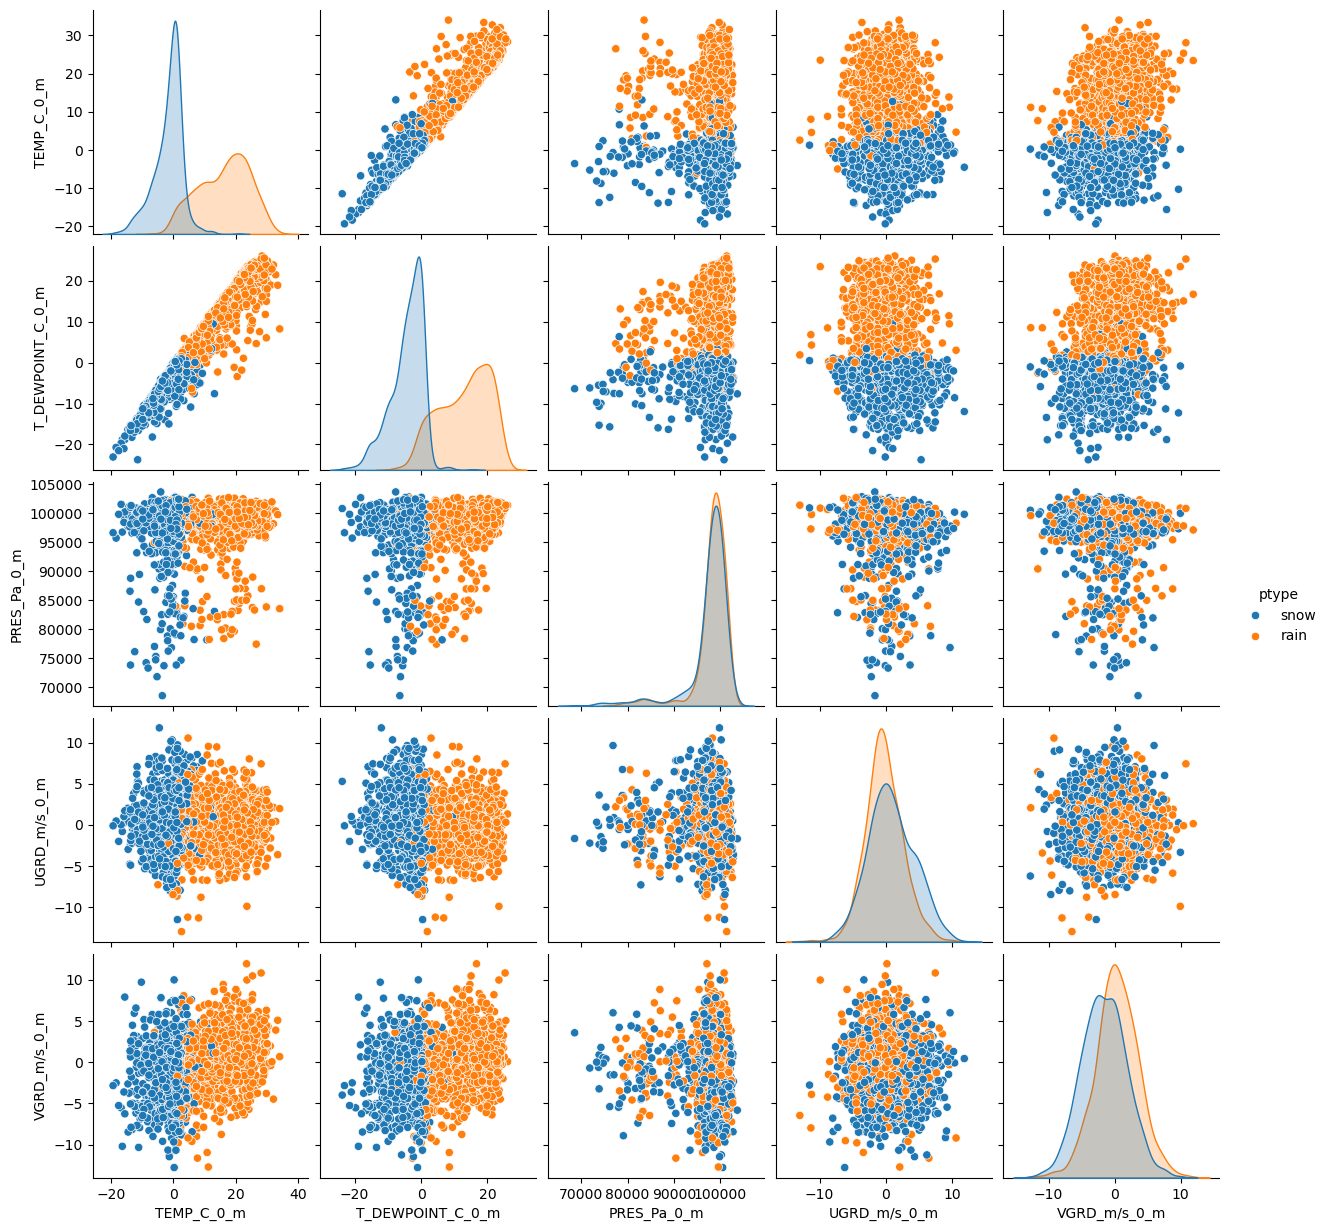

In [6]:
sns.pairplot(df, hue='ptype')

Notice any trends so far? What input features might be the most important? 

Next we can plot the Correlation Matrix. As the name suggests, this will show us the correlation between variables. The closer the absolute value is to 1, the stronger the relationship between these variables is. Notice how all of our diagonal values equal to 1? this is because they represent the correlation between a variable and itself. Can you see which other variables have strong correlations?

For further reading, visit [Correlation Matrix, Demystified](https://towardsdatascience.com/correlation-matrix-demystified-3ae3405c86c1)

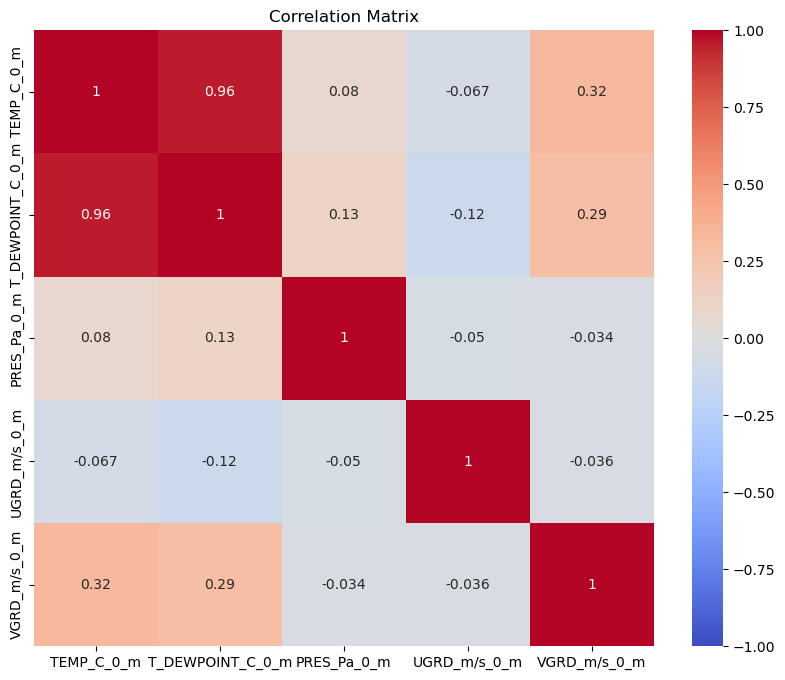

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include=['number']).corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()

## Splitting Datasets

In this section we will learn how to split our data into the training, validation, and testing sets. As the name suggests, training set is used to teach the model about the data, while validation and testing sets are used to asses the performance of the model. 
To learn more about the differences between the three, read the following article: [What is the Difference Between Test and Validation Datasets?](https://machinelearningmastery.com/difference-test-validation-datasets/) Or browse through this module to also learn more details about the ML framework: [Machine Learning Foundations in the Earth Systems Sciences](https://elearning.unidata.ucar.edu/dataeLearning/Cybertraining/foundations/)


In [8]:
from sklearn.model_selection import train_test_split

For this notebook, we will be doing a regression problem. The ptype variable will just be used for EDA. This example uses Temperature, Dewpoint Temperature, Wind Components (U and V), and other atmospheric variables to predict Pressure (PRES_Pa_0_m).

Pressure is fundamental to understanding weather systems - it drives wind patterns, influences storm development, and is key to weather forecasting. By predicting pressure, we're examining how temperature and moisture work together to influence atmospheric conditions.

In [9]:
X = df[['TEMP_C_0_m', 'T_DEWPOINT_C_0_m', 'UGRD_m/s_0_m', 'VGRD_m/s_0_m', 'PRES_Pa_0_m' ]]
y = df['ptype']

In [10]:
# Splitting into training and temporary set (70% training, 30% temporary)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Splitting the temporary set into testing and validation sets (20% testing, 10% validation of the original dataset)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

## Scaling Your Data

After we split the data, we must scale it. Scaling helps us make sure all features, or variables, contribute equally to the model. We will be using [scikit-learn's `StandardScaler()` function](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler), which standardizes our features by substracting the mean from each observation and then dividing by the standard deviation.

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
# Initialize the scaler
scaler = StandardScaler()

In the following code, the `fit_transform()` function calculates the mean and standard deviation (fit) of `X_train`, and then uses those parameters to scale the data (transform).

In [13]:
# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing and validation data using the same scaler
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

Notice how we are using `transform()` on our testing and validation data instead. This allows us to use the same mean and invariance as in the training set and keep the testing/validation data "unseen". This last part is especially important to maintain an unbiased model. 

The following article provides a more detailed explanation: [What and why behind fit_transform() and transform() in scikit-learn!](https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe)

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Note</p>
    Always scale datasets after splitting to prevent data leakage!
</div>

## Machine Learning

### Training

We will use a linear regression model:

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
# Initialize the Logistic Regression model
model = LogisticRegression()

In [16]:
# Train the model with the training data
model.fit(X_train_scaled, y_train)

LogisticRegression()

Next step, let's use the testing data and plot the new predicted values vs true values.

In [17]:
# Predicting the Test set results
y_pred = model.predict(X_test_scaled)

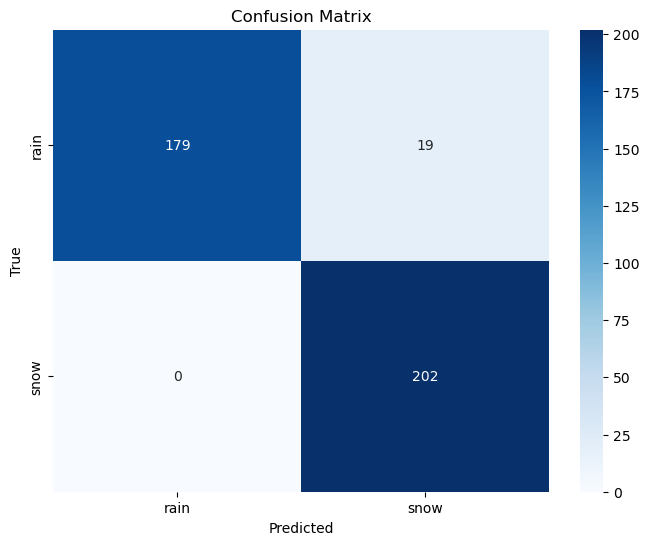

In [18]:
from sklearn.metrics import confusion_matrix

# Get the unique class labels
class_labels = model.classes_  # If using sklearn model
# OR
class_labels = np.unique(y_test)  # Alternative way

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create heatmap with labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Classification Metrics

In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, balanced_accuracy_score

# Get various metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label='rain')

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Accuracy: 0.953
Precision: 1.000
Recall: 0.904
F1 Score: 0.950


Accuracy, Recall, and F1 Score are key metrics used to evaluate classification models, each providing different insights into model performance.

Accuracy measures the overall proportion of correct predictions (both classes) out of all predictions made. While intuitive, accuracy alone can be misleading, especially if one is more interested in a specific class's performance. In your rain vs snow classification, an accuracy of 0.85 would mean the model correctly predicts the weather condition 85% of the time.

Recall (also known as sensitivity) measures the proportion of actual positive cases (rain) that were correctly identified. For example, a recall of 0.90 means the model correctly identified 90% of all actual rain events. This is particularly important when missing a positive case (rain) could have significant consequences.

The F1 Score provides a balanced measure by combining precision (accuracy of positive predictions) and recall into a single metric. It ranges from 0 to 1, where 1 represents perfect precision and recall. The F1 Score is particularly useful for balanced datasets like yours, as it gives equal weight to both precision and recall, providing a more comprehensive view of the model's performance than any single metric alone.

### Now let's try it on the validation set

At this point we could make some changes to our model based on the metrics we got after testing and repeat the training and testing process. Once we are done we can proceed to validate model:

In [20]:
# Predicting the Validation set results
y_val_pred = model.predict(X_val_scaled)

# Get various metrics for validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
precision_val, recall_val, f1_val, _ = precision_recall_fscore_support(y_val, y_val_pred, average='binary', pos_label='rain')

print(f"Accuracy on Validation Set: {accuracy_val:.3f}")
print(f"Precision on Validation Set: {precision_val:.3f}")
print(f"Recall on Validation Set: {recall_val:.3f}")
print(f"F1 Score on Validation Set: {f1_val:.3f}")

Accuracy on Validation Set: 0.940
Precision on Validation Set: 0.956
Recall on Validation Set: 0.916
F1 Score on Validation Set: 0.935


## Different dataset, different results?

Let's look at another dataset. This dataset just has snow and freezing rain as the p-types, so overall it will be colder. Let's see if we get similar results.

In [21]:
df_frza = pd.read_parquet(r'../ptype_data/ptype_sampled_frza.parquet')

In [22]:
df_frza.describe()

TEMP_C_0_m  T_DEWPOINT_C_0_m    PRES_Pa_0_m  UGRD_m/s_0_m  \
count  2000.000000       2000.000000    2000.000000   2000.000000   
mean     -1.224230         -3.480852   97853.976562     -0.276727   
std       4.247178          4.457617    4084.322754      3.331566   
min     -19.303024        -24.025223   67854.320312    -11.178705   
25%      -3.115570         -5.516388   97356.414062     -2.465180   
50%      -0.692780         -2.609085   98588.738281     -0.602569   
75%       0.643044         -0.705284   99923.923828      1.779485   
max      27.657043         25.156921  103556.835938     16.121258   

       VGRD_m/s_0_m  
count   2000.000000  
mean      -1.568403  
std        3.333238  
min      -14.452679  
25%       -3.786891  
50%       -1.692378  
75%        0.665858  
max       10.243851

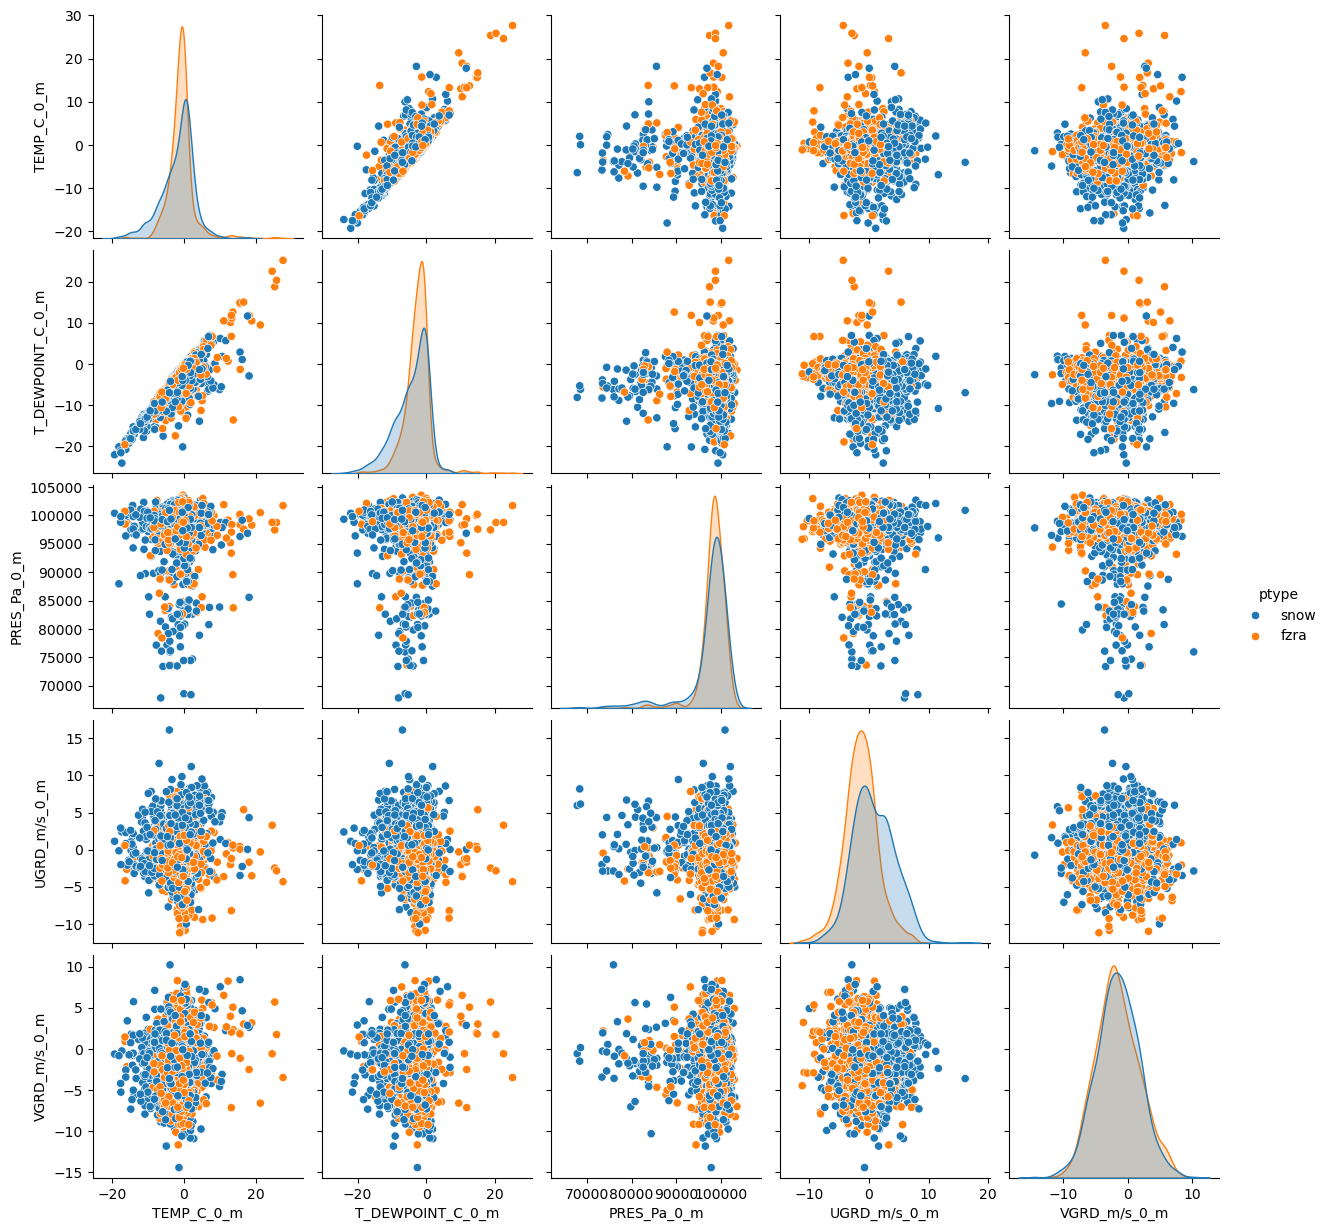

In [23]:
sns.pairplot(df_frza, hue='ptype')

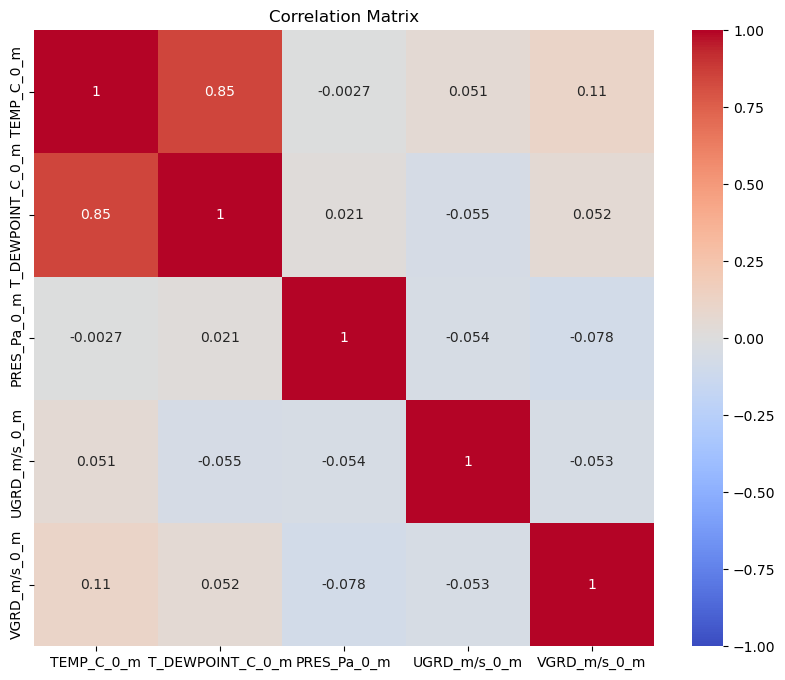

In [24]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_frza.select_dtypes(include=['number']).corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()

What are the differences in EDA compared to rain vs snow? Do you expect this to do better or worse compared to rain vs snow?

### Split up the data & Scale

The following code is a bit compressed, but is the same line for line as above, just with a new dataset.

In [25]:
X2 = df_frza[['TEMP_C_0_m','UGRD_m/s_0_m','T_DEWPOINT_C_0_m', 'VGRD_m/s_0_m', 'PRES_Pa_0_m' ]]
y2 = df_frza['ptype']

In [26]:
# Splitting into training and temporary set (70% training, 30% temporary)
X_train2, X_temp2, y_train2, y_temp2 = train_test_split(X2, y2, test_size=0.3, random_state=42)

# Splitting the temporary set into testing and validation sets (20% testing, 10% validation of the original dataset)
X_test2, X_val2, y_test2, y_val2 = train_test_split(X_temp2, y_temp2, test_size=1/3, random_state=42)

In [27]:
# Initialize the scaler
scaler = StandardScaler()

In [28]:
# Fit the scaler to the training data and transform it
X_train_scaled2 = scaler.fit_transform(X_train2)

# Transform the testing and validation data using the same scaler
X_test_scaled2 = scaler.transform(X_test2)
X_val_scaled2 = scaler.transform(X_val2)

Notice the new model! We will be using a [Decision Tree](https://scikit-learn.org/stable/modules/tree.html). If you want to learn more, here is a StatQuest [video](https://www.youtube.com/watch?v=_L39rN6gz7Y).

In [29]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

In [30]:
# Train the model with the training data
model.fit(X_train_scaled2, y_train2)

DecisionTreeClassifier()

### Test Set ML

In [31]:
# Predicting the Test set results
y_pred2 = model.predict(X_test_scaled2)

In [32]:
# Calculate classification metrics for test set
accuracy = accuracy_score(y_test2, y_pred2)
precision, recall, f1, _ = precision_recall_fscore_support(y_test2, y_pred2, average='binary', pos_label='snow')

print(f"Accuracy on Test Set: {accuracy:.3f}")
print(f"Precision on Test Set: {precision:.3f}")
print(f"Recall on Test Set: {recall:.3f}")
print(f"F1 Score on Test Set: {f1:.3f}")

Accuracy on Test Set: 0.645
Precision on Test Set: 0.638
Recall on Test Set: 0.688
F1 Score on Test Set: 0.662


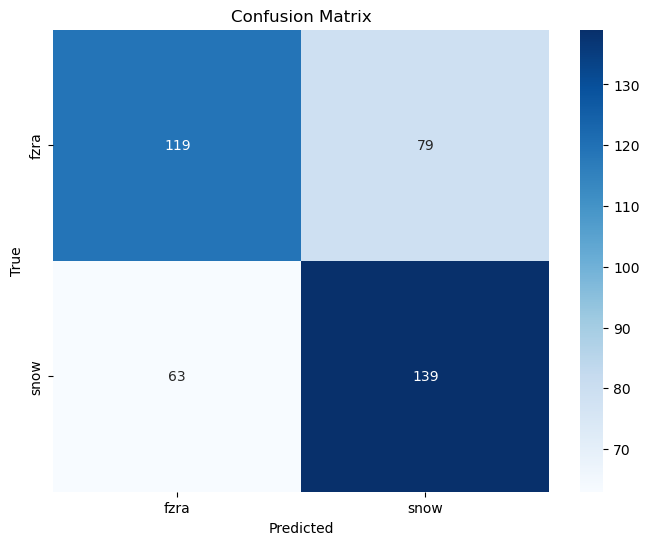

In [33]:
# Get the unique class labels
class_labels = model.classes_  # If using sklearn model
# OR
class_labels = np.unique(y_test2)  # Alternative way

# Create confusion matrix
cm = confusion_matrix(y_test2, y_pred2)

# Create heatmap with labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

What do you notice in this confusion matrix compared to the one with rain vs snow?

### Validation Set ML 

In [34]:
# Predicting the Validation set results
y_val_pred2 = model.predict(X_val_scaled2)

# Calculate classification metrics
accuracy_val = accuracy_score(y_val2, y_val_pred2)
precision_val, recall_val, f1_val, _ = precision_recall_fscore_support(y_val2, y_val_pred2, average='binary', pos_label='fzra')

print(f"Accuracy on Validation Set: {accuracy_val:.3f}")
print(f"Precision on Validation Set: {precision_val:.3f}")
print(f"Recall on Validation Set: {recall_val:.3f}")
print(f"F1 Score on Validation Set: {f1_val:.3f}")

Accuracy on Validation Set: 0.625
Precision on Validation Set: 0.606
Recall on Validation Set: 0.600
F1 Score on Validation Set: 0.603


### More Questions

1. What do you see comparing the metrics; freezing rain vs snow and snow vs rain? Is this what you expected?
   
1. Is the Decision Tree model consistent between testing and validations sets for both experiments? Could we potentially use a more complex model?
   
1. How many lines of code does it take to do a quick ML analysis with a testing, training, and validation dataset?

---

## Summary
In this notebook we learned:
1. What Exploratory Data Analysis is and some useful functions that can help you in the process of understading your data.
1. How and why we split and scale data
1. How to train your model and evaluate its accuracy afterwards

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
1. [Scikit-learn](https://scikit-learn.org/stable/)
1. [Correlation Matrix, Demystified](https://towardsdatascience.com/correlation-matrix-demystified-3ae3405c86c1)
1. [What is the Difference Between Test and Validation Datasets?](https://machinelearningmastery.com/difference-test-validation-datasets/)
1. [Machine Learning Foundations in the Earth Systems Sciences](https://elearning.unidata.ucar.edu/dataeLearning/Cybertraining/foundations/)
1. [Scikit-learn's StandardScaler Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)
1. [What and why behind fit_transform() and transform() in scikit-learn!](https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe)
1. [is
R2: Downsides and Potential Pitfalls for ESS ML Predic](https://www.unidata.ucar.edu/blogs/news/entry/r-sup-2-sup-downsides)
1. [Scikit-learn's Decision Trees](https://scikit-learn.org/stable/modules/tree.html)
1. [StatQuest video: Decision and Classification Trees, Clearly Explained!!!](https://www.youtube.com/watch?v=_L39rN6gz7Y)tion